# English to Khmer seq2seq transformer

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import re
import unicodedata
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-12-14 07:55:58.184851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-14 07:55:58.254200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 07:55:59.575730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-14 07:55:59.575730: I tensorflow/core/util/port.cc:153] oneDNN custom op

In [2]:
# config
EMBED_DIM = 128
LATENT_DIM = 256
NUM_HEADS = 4
BATCH_SIZE = 64
EPOCHS = 50

BASE_DIR = os.path.dirname(os.path.abspath('.'))
DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "eng_khm_data.csv")
MODEL_PATH = os.path.join(BASE_DIR, "models", "transformer_eng2khm.keras")
ASSETS_PATH = os.path.join(BASE_DIR, "data", "processed", "transformer_eng2khm_assets.pkl")
RESULTS_PATH = os.path.join(BASE_DIR, "results")

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(ASSETS_PATH), exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

## Data Preprocessing

In [3]:
# load and preprocess data
df = pd.read_csv(DATA_PATH)
dataset = []

for _, row in df.iterrows():
    normalized_eng = re.sub(r"[^a-z]", "", row['eng'].lower())
    
    normalized_khm = re.sub(r"[^\u1780-\u17FF]", "", row['khm'])
    normalized_khm = unicodedata.normalize('NFC', normalized_khm)

    dataset.append((normalized_eng, normalized_khm))

print(f"Dataset size: {len(dataset)}")
print("Sample pairs:", dataset[:3])

Dataset size: 28576
Sample pairs: [('brodae', 'ប្រដែ'), ('aasangkheyy', 'អសង្ខៃយ'), ('chhatkophey', 'ឆាតកភ័យ')]


In [4]:
# tokenize
eng_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
eng_tokenizer.fit_on_texts([pair[0] for pair in dataset])

khm_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
khm_tokenizer.fit_on_texts(["\t", "\n"] + [pair[1] for pair in dataset])

print(f"English vocab size: {len(eng_tokenizer.word_index) + 1}")
print(f"Khmer vocab size: {len(khm_tokenizer.word_index) + 1}")

English vocab size: 28
Khmer vocab size: 81


In [5]:
# verify special tokens are in the tokenizer
print("Checking special tokens in khm_tokenizer:")
print(f"'\\t' token index: {khm_tokenizer.word_index.get('\\t', 'NOT FOUND')}")
print(f"'\\n' token index: {khm_tokenizer.word_index.get('\\n', 'NOT FOUND')}")
print(f"\ntokens in eng_tokenizer: {list(eng_tokenizer.word_index.items())}")
print(f"\ntokens in khm_tokenizer: {list(khm_tokenizer.word_index.items())}")

Checking special tokens in khm_tokenizer:
'\t' token index: NOT FOUND
'\n' token index: NOT FOUND

tokens in eng_tokenizer: [('<unk>', 1), ('a', 2), ('o', 3), ('h', 4), ('e', 5), ('n', 6), ('r', 7), ('k', 8), ('t', 9), ('u', 10), ('s', 11), ('m', 12), ('b', 13), ('i', 14), ('c', 15), ('p', 16), ('l', 17), ('g', 18), ('y', 19), ('v', 20), ('d', 21), ('j', 22), ('z', 23), ('f', 24), ('w', 25), ('x', 26), ('q', 27)]

tokens in khm_tokenizer: [('<unk>', 1), ('្', 2), ('ា', 3), ('រ', 4), ('ក', 5), ('ស', 6), ('ប', 7), ('ត', 8), ('ន', 9), ('ម', 10), ('ង', 11), ('ិ', 12), ('ល', 13), ('អ', 14), ('ច', 15), ('ុ', 16), ('វ', 17), ('ទ', 18), ('យ', 19), ('់', 20), ('ព', 21), ('ំ', 22), ('ហ', 23), ('ោ', 24), ('ជ', 25), ('េ', 26), ('គ', 27), ('ី', 28), ('ណ', 29), ('ញ', 30), ('ដ', 31), ('ូ', 32), ('ភ', 33), ('ែ', 34), ('ធ', 35), ('ខ', 36), ('ើ', 37), ('៉', 38), ('ះ', 39), ('ឹ', 40), ('ួ', 41), ('ឡ', 42), ('ថ', 43), ('ផ', 44), ('ៀ', 45), ('័', 46), ('ៈ', 47), ('ឆ', 48), ('៍', 49), ('ៃ', 50), ('៊', 51), 

In [6]:
# create sequences
encoder_inputs, decoder_inputs, decoder_targets = [], [], []
max_eng_len = max(len(pair[0]) for pair in dataset) or 1
max_khm_len = max(len(pair[1]) for pair in dataset) or 1

for eng, khm in dataset:
    # encoder sequence (english)
    eng_seq = eng_tokenizer.texts_to_sequences([eng])[0]
    encoder_inputs.append(eng_seq)

    # decoder sequences (khmer)
    khm_seq = khm_tokenizer.texts_to_sequences([khm])[0]
    decoder_input = [khm_tokenizer.word_index['\t']] + khm_seq
    decoder_target = khm_seq + [khm_tokenizer.word_index['\n']]
    
    decoder_inputs.append(decoder_input)
    decoder_targets.append(decoder_target)

X_train_full = pad_sequences(encoder_inputs, maxlen=max_eng_len, padding='post')
decoder_input_data_full = pad_sequences(decoder_inputs, maxlen=max_khm_len + 1, padding='post')
decoder_target_data_full = pad_sequences(decoder_targets, maxlen=max_khm_len + 1, padding='post')

# Train/test split
X_train, X_test, dec_in_train, dec_in_test, dec_tgt_train, dec_tgt_test = train_test_split(
    X_train_full, decoder_input_data_full, decoder_target_data_full, 
    test_size=0.2, random_state=42
)

num_encoder_tokens = len(eng_tokenizer.word_index) + 1
num_decoder_tokens = len(khm_tokenizer.word_index) + 1

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Max English length: {max_eng_len}")
print(f"Max Khmer length: {max_khm_len}")

Training samples: 22860
Test samples: 5716
Max English length: 25
Max Khmer length: 24


## Build Transformer Model

In [7]:
# build transformer model
# Encoder (English)
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
enc_emb = Embedding(input_dim=num_encoder_tokens, output_dim=EMBED_DIM)(encoder_inputs)
encoder_dense = Dense(LATENT_DIM, activation='relu')(enc_emb)

# Decoder (Khmer)
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb = Embedding(input_dim=num_decoder_tokens, output_dim=EMBED_DIM)(decoder_inputs)
decoder_dense_input = Dense(LATENT_DIM, activation='relu')(dec_emb)

# Multi-head attention (encoder->decoder)
attention_output = tf.keras.layers.MultiHeadAttention(
    num_heads=NUM_HEADS, key_dim=LATENT_DIM
)(decoder_dense_input, encoder_dense)
attention_output = LayerNormalization()(attention_output + decoder_dense_input)
dropout_output = Dropout(0.2)(attention_output)

# Output layer
decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(dropout_output)

# Build and compile model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='transformer_eng2khm')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1765698963.079267  119178 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "transformer_eng2khm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │     10,368 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │      3,584 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 256) │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 256) │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ dense_1[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ multi_head_atten… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 256) │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 81)  │     20,817 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,153,233 (4.40 MB)

 Trainable params: 1,153,233 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [8]:
# train
checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

history = model.fit(
    [X_train, dec_in_train],
    np.expand_dims(dec_tgt_train, -1),
    validation_data=([X_test, dec_in_test], np.expand_dims(dec_tgt_test, -1)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/50


2025-12-14 07:56:06.886368: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fcfb4004840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-14 07:56:06.886522: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-14 07:56:07.009467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-14 07:56:07.296859: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-14 07:56:07.296859: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-14 07:56:07.557170: I external/local_xla/x

 21/358 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6155 - loss: 1.8237

I0000 00:00:1765698970.670025  119905 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7688 - loss: 0.9182

2025-12-14 07:56:13.793875: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7693 - loss: 0.9152

2025-12-14 07:56:17.131482: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-14 07:56:17.993577: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-14 07:56:17.993577: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from None to 0.60740, saving model to /teamspace/studios/this_studio/khm_romanization/models/transformer_eng2khm.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.7956 - loss: 0.7386 - val_accuracy: 0.8125 - val_loss: 0.6074
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.7956 - loss: 0.7386 - val_accuracy: 0.8125 - val_loss: 0.6074
Epoch 2/50
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8122 - loss: 0.6110
Epoch 2: val_loss improved from 0.60740 to 0.58967, saving model to /teamspace/studios/this_studio/khm_romanization/models/transformer_eng2khm.keras

Epoch 2: val_loss improved from 0.60740 to 0.58967, saving model to /teamspace/studios/this_studio/khm_romanization/models/transformer_eng2khm.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8130 - loss: 0.6051 - val_accuracy: 0.8157 - val_loss: 0.5897
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8130 - loss: 0.6051 - val_accuracy: 

In [9]:
# save assets
assets = {
    "eng_tokenizer": eng_tokenizer,
    "khm_tokenizer": khm_tokenizer,
    "max_eng_len": max_eng_len,
    "max_khm_len": max_khm_len
}

with open(ASSETS_PATH, "wb") as file:
    pickle.dump(assets, file)

print(f"Model saved to: {MODEL_PATH}")
print(f"Assets saved to: {ASSETS_PATH}")

Model saved to: /teamspace/studios/this_studio/khm_romanization/models/transformer_eng2khm.keras
Assets saved to: /teamspace/studios/this_studio/khm_romanization/data/processed/transformer_eng2khm_assets.pkl


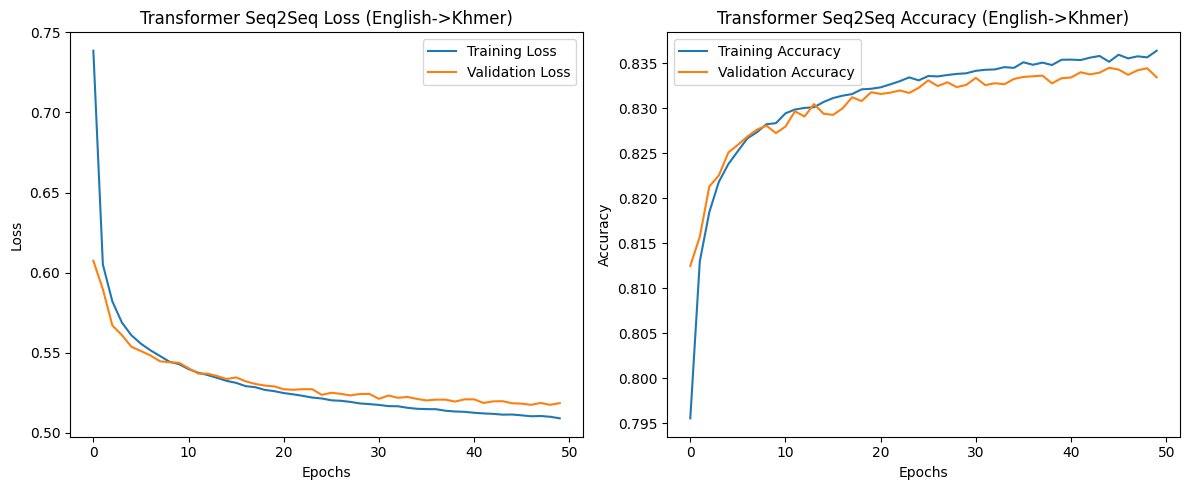

In [10]:
# plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Seq2Seq Loss (English->Khmer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Seq2Seq Accuracy (English->Khmer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'transformer_eng2khm_training_curves.png'))
plt.show()

## Inference

In [11]:
# load model and assets for testing
with open(ASSETS_PATH, "rb") as file:
    assets = pickle.load(file)

eng_tokenizer = assets["eng_tokenizer"]
khm_tokenizer = assets["khm_tokenizer"]
max_eng_len = assets["max_eng_len"]
max_khm_len = assets["max_khm_len"]

model = tf.keras.models.load_model(MODEL_PATH)
print("Model and assets loaded successfully")


def transliterate(english_text):
    """
    Transliterate English text to Khmer using the trained transformer model.
    
    Args:
        english_text: Input English text string
        
    Returns:
        Transliterated Khmer text
    """
    # clean input
    english_text = str(english_text).strip()
    english_text = re.sub(r"[^a-z]", "", english_text.lower())
    
    if not english_text:
        return ""
    
    # encode input
    eng_seq = eng_tokenizer.texts_to_sequences([english_text])
    encoder_input = pad_sequences(eng_seq, maxlen=max_eng_len, padding='post')
    
    # initialize decoder input with start token
    decoder_input = np.zeros((1, max_khm_len + 1), dtype=np.int32)
    decoder_input[0, 0] = khm_tokenizer.word_index['\t']
    
    # decode character by character
    decoded_chars = []
    
    for i in range(max_khm_len):
        # predict next character
        predictions = model.predict([encoder_input, decoder_input], verbose=0)
        
        # get the character at current position
        char_index = np.argmax(predictions[0, i, :])
        
        # convert index to character
        if char_index == 0:
            # padding token, skip
            break
        
        char = khm_tokenizer.index_word.get(char_index, '')
        
        # stop if end token
        if char == '\n':
            break
        
        # skip special tokens in output
        if char not in ['\t', '<unk>']:
            decoded_chars.append(char)
        
        # update decoder input for next position
        if i + 1 < max_khm_len + 1:
            decoder_input[0, i + 1] = char_index
    
    return unicodedata.normalize('NFC', ''.join(decoded_chars))

Model and assets loaded successfully


## Test Transliteration

In [12]:
transliterate("hello")

'ល'

In [13]:
transliterate("kdas")

'ស្ដា'

In [14]:
transliterate("trap")

'ព្រាត'

In [15]:
transliterate("mean luy")

'លំន្លំន្លំន្លំន្លំន្លំន្'